In [1]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import seaborn as sns

import warnings
import os
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [10]:
def plot_clusters(X, model):
    if hasattr(model, 'labels_'):
        y_pred = model.labels_.astype(np)
    else:
        y_pred = model.predict(X)

    ax1 = plt.axes(projection='3d')
    ax1.scatter3D(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], c=y_pred)
    plt.show()

    ax1 = plt.axes(projection='3d')
    ax1.view_init(90,0)
    ax1.scatter3D(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], c=y_pred)
    plt.show()

    ax1 = plt.axes(projection='3d')
    ax1.view_init(0,90)
    ax1.scatter3D(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], c=y_pred)
    plt.show()

def TSNE_scatter(tsne_model, model, data):
    x = tsne_model.fit_transform(data)
    colors = model.fit_predict(data)
    palette = np.array(sns.color_palette("hls", 10))

    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

def count_clustering_scores(X, model, score_fun):

    X = X.to_numpy()
    model_instance = model
    labels = model_instance.fit_predict(X)

    return score_fun(X, labels)

def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def std_dev_of_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

In [3]:
df = pd.read_csv("../preprocessed_data/preprocessed_pca_train.csv")

# DBSCAN

## Traning, visualisation

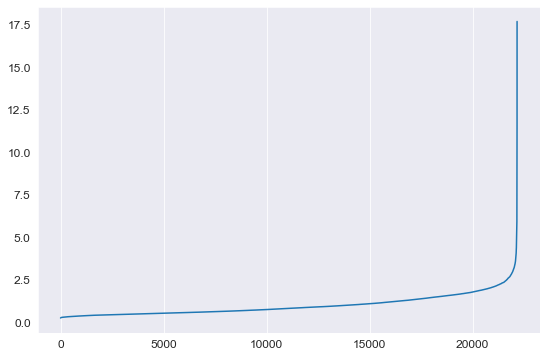

In [4]:
minPts = 24
nbrs = NearestNeighbors(n_neighbors=minPts).fit(df)
distances, indices = nbrs.kneighbors(df)
distanceDec = sorted(distances[:,minPts-1])

fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)
ax1.plot(list(range(1, df.shape[0] + 1)), distanceDec)
plt.grid(axis='y')
plt.show()

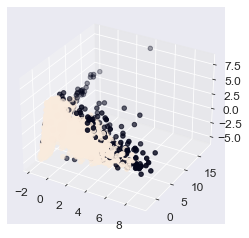

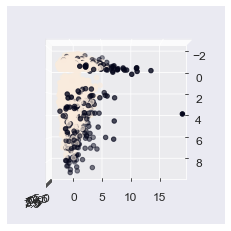

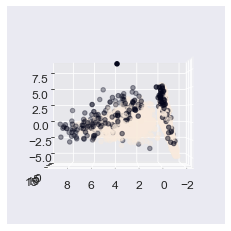

In [6]:
dbs = DBSCAN(eps=2.3, min_samples=24).fit(df)
plot_clusters(df, dbs)

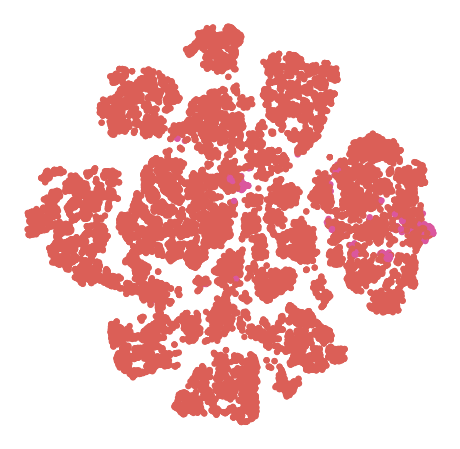

In [9]:
TSNE_scatter(TSNE(n_components=3, random_state=42, n_jobs=1), dbs, df)

## Results

In [12]:
metrices = {
    'min dist between clusters': min_interclust_dist,
    'mean dist in clust': mean_inclust_dist,
    'std dev dist in clust': std_dev_of_inclust_dist,
    'mean dist to clust center': mean_dist_to_center,
    'silhouette': silhouette_score
}

models = {
    'DBSCAN': dbs
}

res = pd.DataFrame()
for model_key in models:
    for metric_key in metrices:
        res.loc[model_key, metric_key] = count_clustering_scores(X=df, model=models[model_key],
                                                                score_fun=metrices[metric_key])
res

,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette
DBSCAN,0.641751,5.944012,2.433605,4.212713,0.528094


## Interpretation

In [11]:
clusters = dbs.fit_predict(df)
row_data = pd.read_csv("../preprocessed_data/train.csv")
res_df = row_data.join(pd.DataFrame({'cluster':clusters}))
res_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,cluster
0,26,admin.,single,secondary,no,94,no,no,cellular,29,jan,171,1,-1,0,unknown,no,0
1,50,services,married,secondary,yes,0,no,no,telephone,31,jul,35,9,-1,0,unknown,no,0
2,56,entrepreneur,married,secondary,no,535,yes,yes,unknown,16,jun,345,4,-1,0,unknown,no,0
3,58,technician,married,secondary,no,7554,no,no,telephone,9,feb,167,1,469,1,success,no,0
4,31,blue-collar,single,secondary,no,23,no,no,cellular,21,nov,116,1,-1,0,unknown,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22147,44,management,single,tertiary,no,1277,yes,no,cellular,17,apr,77,1,268,4,other,no,0
22148,45,management,single,tertiary,no,2048,yes,no,cellular,18,oct,310,1,804,1,failure,yes,-1
22149,37,management,married,tertiary,no,-76,yes,no,cellular,28,jan,230,1,204,1,other,no,0
22150,41,blue-collar,married,primary,no,402,no,no,unknown,17,jun,114,17,-1,0,unknown,no,0


In [12]:
res_df.cluster.value_counts()

 0    21932
-1      220
Name: cluster, dtype: int64

In [21]:
def get_cluster_data(data):

    col = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact',
           'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
    cl1 = []
    cl0 = []
    for col in col:
        if isinstance(data[col][0], str):
            print( '\ncluster 1')
            print(data.where(data['cluster'] == 1)[col].value_counts(normalize = True))
            print('\n' + 'cluster 0')
            print(data.where(data['cluster'] == 0)[col].value_counts(normalize = True))
            print('\n')
        else:
            cl1.append(data.where(data['cluster'] == 1)[col].median())
            cl0.append(data.where(data['cluster'] == 0)[col].median())
    return pd.DataFrame([col,cl1,cl0])

In [22]:
print(get_cluster_data(res_df))


cluster 1
Series([], Name: job, dtype: float64)

cluster 0
blue-collar      0.216487
management       0.206548
technician       0.168111
admin.           0.114171
services         0.094884
retired          0.049517
self-employed    0.035291
entrepreneur     0.032099
unemployed       0.027950
housemaid        0.027859
student          0.021020
unknown          0.006064
Name: job, dtype: float64



cluster 1
Series([], Name: marital, dtype: float64)

cluster 0
married     0.605326
single      0.281142
divorced    0.113533
Name: marital, dtype: float64



cluster 1
Series([], Name: education, dtype: float64)

cluster 0
secondary    0.518694
tertiary     0.287844
primary      0.151058
unknown      0.042404
Name: education, dtype: float64



cluster 1
Series([], Name: default, dtype: float64)

cluster 0
no     0.979756
yes    0.020244
Name: default, dtype: float64



cluster 1
Series([], Name: housing, dtype: float64)

cluster 0
yes    0.556402
no     0.443598
Name: housing, dtype: float64

In [15]:
def draw_bar_plots(data):
    clusters = data.cluster
    categorical_columns = data.select_dtypes(include='object').columns

    for column in categorical_columns:
        plt.figure(figsize=(8, 6))
        ax = plt.gca()
        counts = data.groupby([column, clusters]).size().unstack()
        counts.plot(kind='bar', ax=ax)
        plt.show()


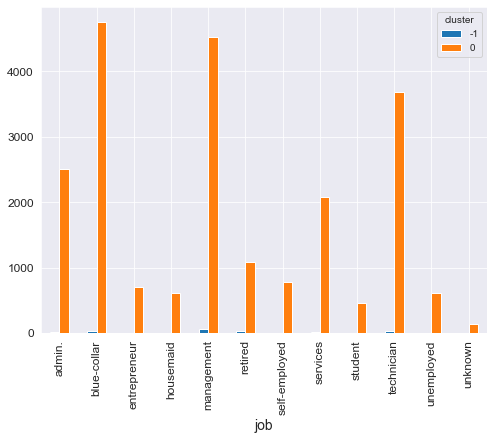

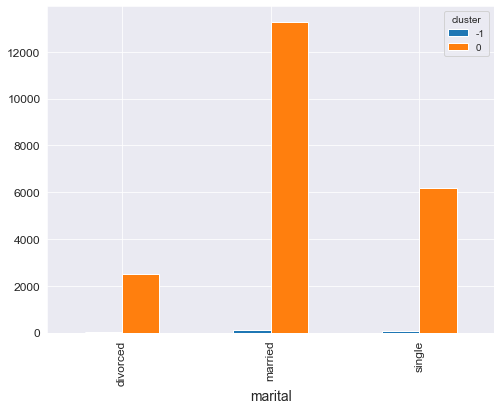

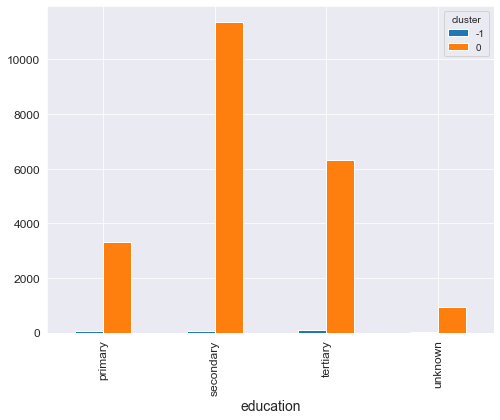

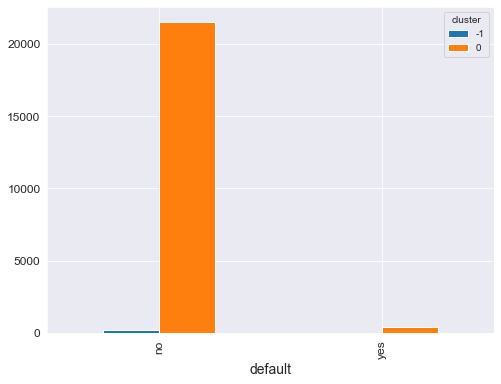

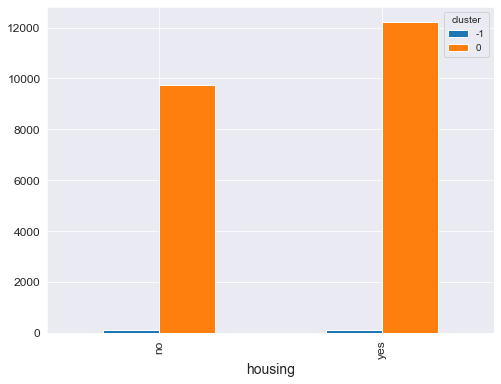

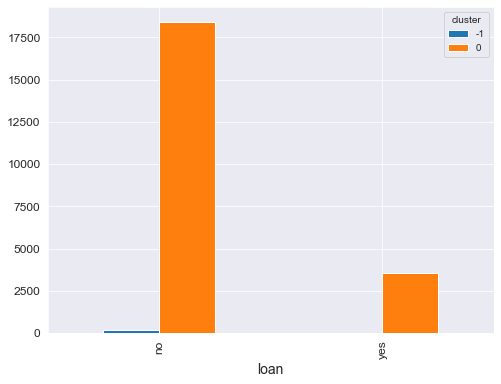

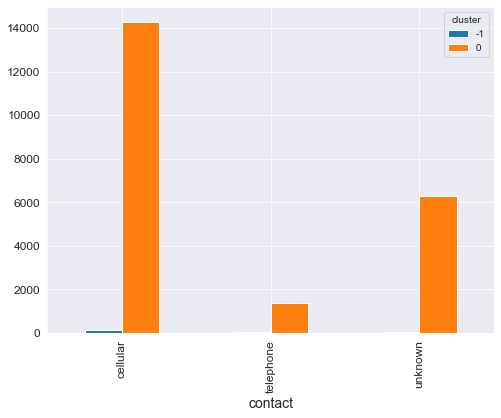

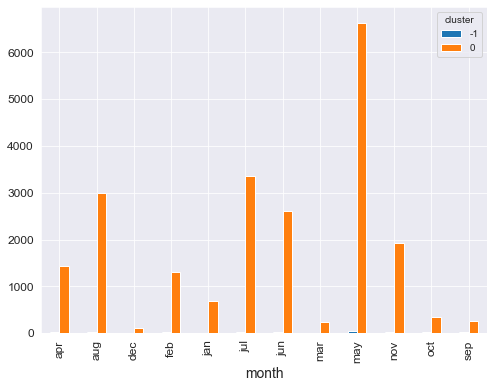

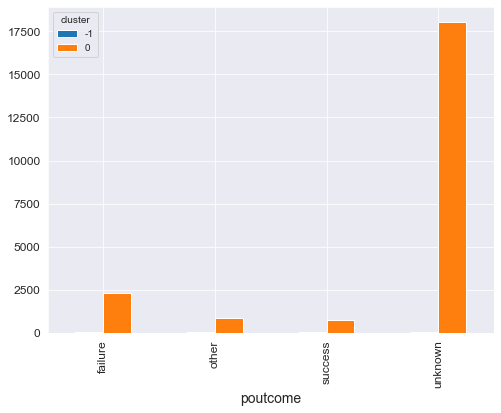

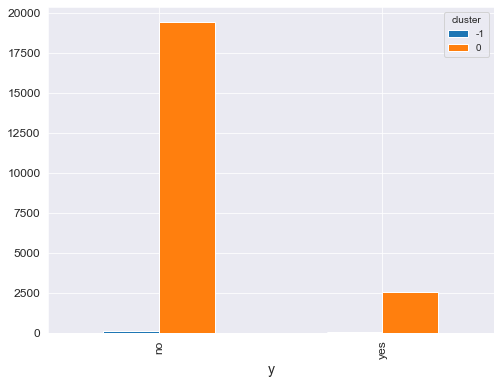

In [16]:
draw_bar_plots(res_df)